# CMPUT 566 Final Project

Sohyun Park

CCID: sohyun2

sohyun2@ualberta.ca

## 1) ML to Audio Data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime

### Audio Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import librosa
import os
from keras.utils import to_categorical
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, plot_confusion_matrix

Using TensorFlow backend.


In [3]:
def wav2mfcc(file_path, augment = False, max_pad_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=8000, duration = 1.024)
    
    if augment == True:
        bins_per_octave = 12
        pitch_pm = 4
        pitch_change =  pitch_pm * 2*(np.random.uniform())   
        wave = librosa.effects.pitch_shift(wave, 
                                          8000, n_steps=pitch_change, 
                                          bins_per_octave=bins_per_octave)
        
        speed_change = np.random.uniform(low=0.9,high=1.1)
        wave = librosa.effects.time_stretch(wave, speed_change)
        wave = wave[:8192]

    duration = wave.shape[0]/sr
    speed_change = 2.0* duration/1.024
    wave = librosa.effects.time_stretch(wave, speed_change)
    wave = wave[:4096]
    
    wave = librosa.util.normalize(wave)
    mfcc = librosa.feature.mfcc(wave, sr=sr, n_mfcc=40, hop_length=int(0.048*sr), n_fft=int(0.096*sr))
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    #print("shape=",mfcc.shape[1], wave.shape[0])
    pad_width = max_pad_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    #mfcc = mfcc[2:24,:]
    return mfcc, duration, sr

def get_data(dir = '', augment= False):
    labels = []
    mfccs = []
    durations = []
    sampling_rates = []
    filenames = []

    for f in tqdm(os.listdir(dir)):
        if f.endswith('.wav'):
            mfcc, duration, sr = wav2mfcc(dir + "/" + f, augment)
            mfccs.append(mfcc)
            durations.append(duration)
            sampling_rates.append(sr)
            # List of labels
            label = f.split('_')[0]
            labels.append(label)
            filenames.append(dir + "/" + f)
    return filenames, np.asarray(mfccs), np.asarray(durations), np.asarray(sampling_rates), to_categorical(labels), labels

In [4]:
filenames, mfccs, durations, sampling_rates, labels, cls_true = get_data('dataset/recordings')

100%|██████████| 1500/1500 [00:10<00:00, 149.32it/s]


In [67]:
dim_1 = mfccs.shape[1]
dim_2 = mfccs.shape[2]
channels = 1

In [68]:
X = mfccs
X = X.reshape((mfccs.shape[0], dim_1*dim_2))
y = labels
true_label = cls_true

In [69]:
X_train, X_test, y_train, y_test, train_label, test_label = train_test_split(X, y, true_label, test_size=0.2, random_state=1)

### Models

**Linear Regression**

In [90]:
from sklearn.linear_model import LinearRegression

dt_started = datetime.datetime.utcnow()
clf = LinearRegression().fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

predict time: 0.061874


In [89]:
preds = clf.predict(X_test)
preds_label = np.argmax(preds, axis=-1)
temp_label = list(map(int, test_label))

print(classification_report(temp_label, preds_label))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.93      0.96      0.95        28
           2       1.00      1.00      1.00        40
           3       0.96      1.00      0.98        25
           4       0.95      1.00      0.98        21
           5       1.00      0.95      0.97        37
           6       0.96      0.90      0.93        30
           7       1.00      0.97      0.98        31
           8       0.93      0.97      0.95        29
           9       0.93      1.00      0.97        28

    accuracy                           0.97       300
   macro avg       0.97      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



**Logistic Regression**

In [10]:
from sklearn.linear_model import LogisticRegression

dt_started = datetime.datetime.utcnow()
clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs').fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, test_label)

predict time: 0.249268


0.9933333333333333

In [11]:
preds = clf.predict(X_test)
print(classification_report(test_label, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.97      1.00      0.98        28
           2       0.98      1.00      0.99        40
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        21
           5       1.00      0.97      0.99        37
           6       1.00      1.00      1.00        30
           7       1.00      0.97      0.98        31
           8       1.00      1.00      1.00        29
           9       1.00      1.00      1.00        28

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



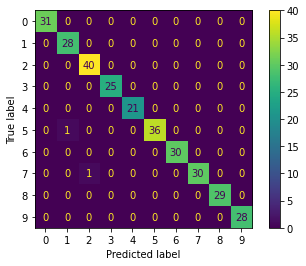

In [13]:
plot_confusion_matrix(clf, X_test, test_label)

**Decision Tree**

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt_started = datetime.datetime.utcnow()
clf = DecisionTreeClassifier(random_state=0).fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, test_label)

predict time: 0.383585


0.8733333333333333

              precision    recall  f1-score   support

           0       0.90      0.87      0.89        31
           1       0.83      0.89      0.86        28
           2       0.90      0.93      0.91        40
           3       0.83      0.80      0.82        25
           4       0.84      1.00      0.91        21
           5       0.91      0.86      0.89        37
           6       0.90      0.87      0.88        30
           7       0.79      0.87      0.83        31
           8       0.86      0.83      0.84        29
           9       0.96      0.82      0.88        28

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.88      0.87      0.87       300



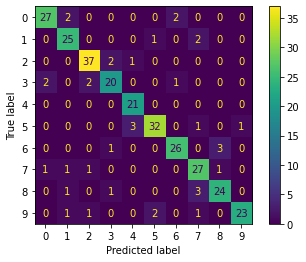

In [15]:
preds = clf.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(clf, X_test, test_label)

**Support Vector Machine**

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

dt_started = datetime.datetime.utcnow()
clf.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, test_label)

predict time: 0.885331


0.9933333333333333

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        21
           5       1.00      1.00      1.00        37
           6       1.00      1.00      1.00        30
           7       1.00      0.97      0.98        31
           8       0.97      1.00      0.98        29
           9       0.97      1.00      0.98        28

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



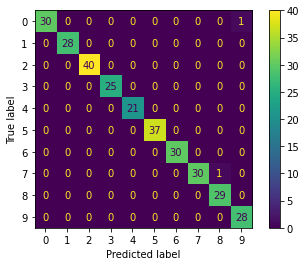

In [17]:
preds = clf.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(clf, X_test, test_label)

**Navie Bayes**

In [18]:
from sklearn.naive_bayes import GaussianNB

dt_started = datetime.datetime.utcnow()
clf = GaussianNB().fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, test_label)

predict time: 0.004263


0.9466666666666667

              precision    recall  f1-score   support

           0       0.96      0.87      0.92        31
           1       0.96      0.96      0.96        28
           2       0.93      0.93      0.93        40
           3       0.86      1.00      0.93        25
           4       0.95      1.00      0.98        21
           5       1.00      0.95      0.97        37
           6       0.90      0.87      0.88        30
           7       1.00      0.94      0.97        31
           8       0.97      1.00      0.98        29
           9       0.93      1.00      0.97        28

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



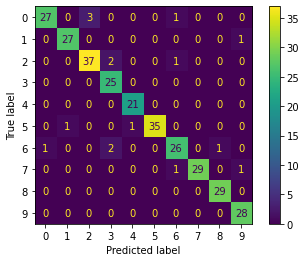

In [19]:
preds = clf.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(clf, X_test, test_label)

**K nearest neighbours**

In [20]:
from sklearn.neighbors import KNeighborsClassifier

dt_started = datetime.datetime.utcnow()
clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, test_label)

predict time: 0.016052


0.9766666666666667

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.96      0.96      0.96        28
           2       0.95      1.00      0.98        40
           3       1.00      0.92      0.96        25
           4       1.00      1.00      1.00        21
           5       1.00      0.97      0.99        37
           6       0.97      0.97      0.97        30
           7       1.00      0.94      0.97        31
           8       0.94      1.00      0.97        29
           9       0.97      1.00      0.98        28

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



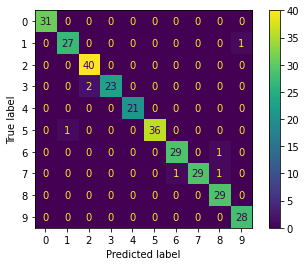

In [21]:
preds = clf.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(clf, X_test, test_label)

**Random Forest**

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)

dt_started = datetime.datetime.utcnow()
clf.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, test_label)

predict time: 1.368922


0.9866666666666667

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        25
           4       0.95      1.00      0.98        21
           5       1.00      0.95      0.97        37
           6       0.94      1.00      0.97        30
           7       1.00      0.94      0.97        31
           8       1.00      1.00      1.00        29
           9       0.97      1.00      0.98        28

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



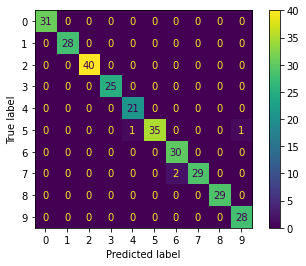

In [23]:
preds = clf.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(clf, X_test, test_label)

## 2) ML to NLP data

In [7]:
import numpy as np 
import pandas as pd
import re

from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, plot_confusion_matrix

### NLP Data Preprocessing

In [5]:
df = pd.read_csv('dataset/IMDB_Dataset.csv')

In [8]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

In [9]:
df['review'] = df['review'].apply(lambda x: cleanhtml(x))

In [95]:
df['label'] = 0

for i in range(len(df)):
    if df['sentiment'][i] == 'positive':
        df['label'][i] = 1
    else: df['label'][i] = 0

In [96]:
X = df['review']
y = df['sentiment']
label = df['label']

X_train, X_test, y_train, y_test, train_label, test_label = train_test_split(X, y, label, test_size=0.2, random_state=42)

### Models

**Linear Regression**

In [97]:
from sklearn.linear_model import LinearRegression

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('Reg', LinearRegression())])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

predict time: 142.372867


In [104]:
preds = pipe.predict(X_test)
preds_label = []

for i in range(len(preds)):
    if preds[i] > 0.5:
        preds_label.append(1)
    else:
        preds_label.append(0)

In [105]:
print(classification_report(test_label, preds_label))

              precision    recall  f1-score   support

           0       0.75      0.74      0.74      4961
           1       0.75      0.76      0.75      5039

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



**Logistic Regression**

In [50]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('Reg', LogisticRegression())])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

pipe.score(X_test, test_label)

predict time: 14.228727


0.9007

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



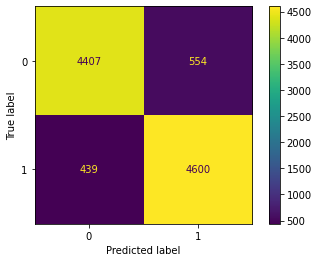

In [40]:
preds = pipe.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(pipe, X_test, test_label)

**Decision tree classifier**

In [53]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('DT', DecisionTreeClassifier())])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

pipe.score(X_test, test_label)

predict time: 100.448668


0.7244

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      4961
           1       0.72      0.73      0.73      5039

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



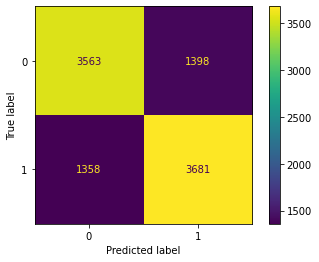

In [54]:
preds = pipe.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(pipe, X_test, test_label)

**Support Vector Machine**

In [55]:
from sklearn.svm import LinearSVC

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('svc', LinearSVC())])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

pipe.score(X_test, y_test)

predict time: 8.751197


0.9027

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90      4961
    positive       0.90      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



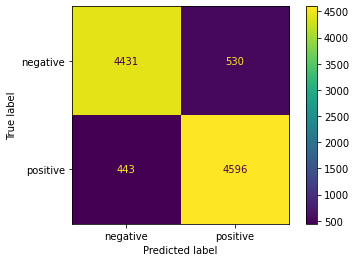

In [56]:
preds = pipe.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(pipe, X_test, y_test)

**Naive Bayes**

In [57]:
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('MNB', MultinomialNB())])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

pipe.score(X_test, test_label)

predict time: 7.704211


0.8631

              precision    recall  f1-score   support

           0       0.84      0.89      0.87      4961
           1       0.88      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



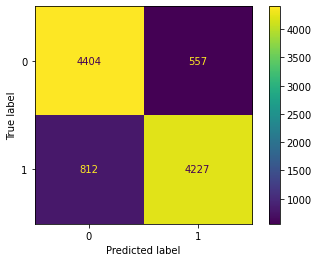

In [58]:
preds = pipe.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(pipe, X_test, test_label)

**k Neighbours Classifier**

In [59]:
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('kNN', KNeighborsClassifier(n_neighbors=2))])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

pipe.score(X_test, test_label)

predict time: 7.434607


0.7468

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      4961
           1       0.81      0.65      0.72      5039

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.74     10000
weighted avg       0.76      0.75      0.74     10000



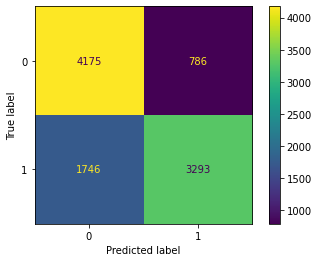

In [60]:
preds = pipe.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(pipe, X_test, test_label)

**Random Forest**

In [61]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('tfidf', TfidfVectorizer()),
                ('RFclf', RandomForestClassifier(max_depth=10, random_state=0))])

dt_started = datetime.datetime.utcnow()
pipe.fit(X_train, train_label)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

pipe.score(X_test, test_label)

predict time: 12.010228


0.8178

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4961
           1       0.81      0.84      0.82      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



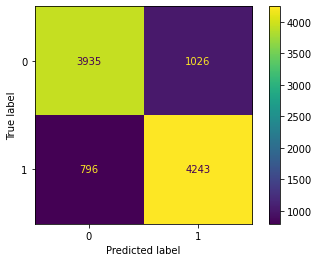

In [62]:
preds = pipe.predict(X_test)
print(classification_report(test_label, preds))
plot_confusion_matrix(pipe, X_test, test_label)

## 3) ML to Vision Data

In [10]:
import numpy as np
import struct

### Vision Data Preprocessing

In [11]:
def readMNISTdata():

    with open('dataset/t10k-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        test_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_data = test_data.reshape((size, nrows*ncols))
    
    with open('dataset/t10k-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        test_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        test_labels = test_labels.reshape((size,1))
    
    with open('dataset/train-images-idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        train_data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_data = train_data.reshape((size, nrows*ncols))
    
    with open('dataset/train-labels-idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        train_labels = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        train_labels = train_labels.reshape((size,1))

    # augmenting a constant feature of 1 (absorbing the bias term)
    train_data = np.concatenate( ( np.ones([train_data.shape[0],1]), train_data ), axis=1)
    test_data  = np.concatenate( ( np.ones([test_data.shape[0],1]),  test_data ), axis=1)
   
    X_train = train_data / 256
    X_test = test_data /256

    return X_train, train_labels, X_test, test_labels


In [12]:
X_train, y_train, X_test, y_test = readMNISTdata()

**Linear Regression**

In [112]:
from sklearn.linear_model import LinearRegression

dt_started = datetime.datetime.utcnow()
clf = LinearRegression().fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

predict time: 3.531763


In [120]:
preds = clf.predict(X_test)
preds_label = preds_label = list(map(int, preds))
temp_label = list(map(int, y_test))

print(classification_report(temp_label, preds_label))

              precision    recall  f1-score   support

          -2       0.00      0.00      0.00         0
          -1       0.00      0.00      0.00         0
           0       0.75      0.38      0.51       980
           1       0.47      0.48      0.47      1135
           2       0.23      0.28      0.25      1032
           3       0.24      0.32      0.28      1010
           4       0.20      0.31      0.24       982
           5       0.16      0.26      0.20       892
           6       0.16      0.21      0.18       958
           7       0.25      0.22      0.23      1028
           8       0.15      0.06      0.09       974
           9       0.47      0.05      0.09      1009
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
  2741788183       0.00      0.00      0.00         0

    accuracy              

**Logistic Regression**

In [29]:
from sklearn.linear_model import LogisticRegression

dt_started = datetime.datetime.utcnow()
clf = LogisticRegression(random_state=0, multi_class='multinomial', solver='lbfgs').fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, y_test)

predict time: 18.840518


0.9261

In [30]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.90      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



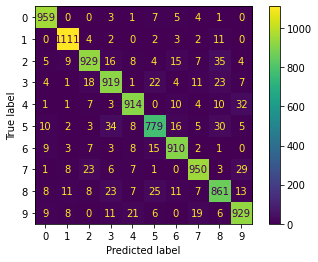

In [31]:
plot_confusion_matrix(clf, X_test, y_test)

**Decision Tree**

In [32]:
from sklearn.tree import DecisionTreeClassifier

dt_started = datetime.datetime.utcnow()
clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, y_test)

predict time: 25.608657


0.8771

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       980
           1       0.95      0.96      0.96      1135
           2       0.87      0.86      0.86      1032
           3       0.83      0.85      0.84      1010
           4       0.86      0.88      0.87       982
           5       0.83      0.84      0.84       892
           6       0.90      0.89      0.89       958
           7       0.92      0.90      0.91      1028
           8       0.83      0.81      0.82       974
           9       0.84      0.84      0.84      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



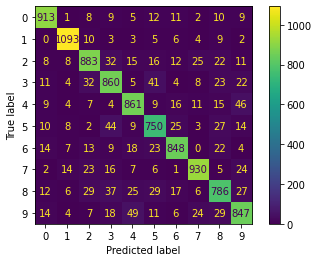

In [33]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(clf, X_test, y_test)

**Support Vector Machine**

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

dt_started = datetime.datetime.utcnow()
clf.fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, y_test)

predict time: 526.361483


0.9665

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.96      0.96      0.96       892
           6       0.98      0.97      0.98       958
           7       0.93      0.96      0.95      1028
           8       0.96      0.95      0.96       974
           9       0.97      0.94      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



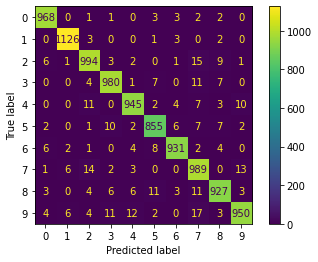

In [42]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(clf, X_test, y_test)

**Navie Bayes**

In [39]:
from sklearn.naive_bayes import GaussianNB

dt_started = datetime.datetime.utcnow()
clf = GaussianNB().fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, y_test)

predict time: 1.49289


0.5558

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       980
           1       0.85      0.95      0.90      1135
           2       0.90      0.26      0.40      1032
           3       0.71      0.35      0.47      1010
           4       0.88      0.17      0.29       982
           5       0.55      0.05      0.09       892
           6       0.65      0.93      0.77       958
           7       0.88      0.27      0.42      1028
           8       0.28      0.67      0.40       974
           9       0.37      0.95      0.53      1009

    accuracy                           0.56     10000
   macro avg       0.69      0.55      0.51     10000
weighted avg       0.69      0.56      0.52     10000



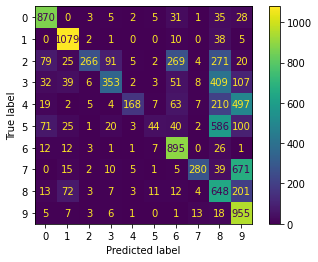

In [40]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(clf, X_test, y_test)

**k Nearest Neighbours**

In [37]:
from sklearn.neighbors import KNeighborsClassifier

dt_started = datetime.datetime.utcnow()
clf = KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, y_test)

predict time: 32.762558


0.9665

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.94      1.00      0.97      1135
           2       0.98      0.95      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



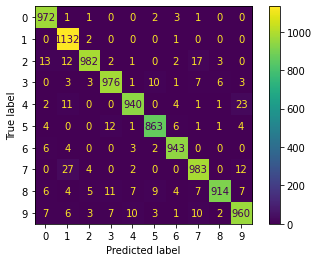

In [38]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))
plot_confusion_matrix(clf, X_test, y_test)

**Random Forest**

In [34]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)

dt_started = datetime.datetime.utcnow()
clf.fit(X_train, y_train)
dt_ended = datetime.datetime.utcnow()
print("predict time:",(dt_ended - dt_started).total_seconds())

clf.score(X_test, y_test)

predict time: 32.085179


0.9482

In [35]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.97      0.99      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.94      0.94      0.94      1010
           4       0.95      0.94      0.94       982
           5       0.96      0.92      0.94       892
           6       0.96      0.97      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.94      0.93      0.93       974
           9       0.89      0.93      0.91      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



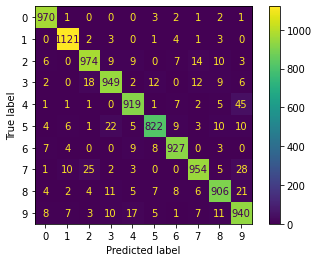

In [36]:
plot_confusion_matrix(clf, X_test, y_test)